In [1]:
# Definitions and functions
%matplotlib inline
import pdb
import sys
import pandas as pd
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import matplotlib
import scipy.signal as sg
import math
import scipy as sp
import socket
import os
import wave
import struct
import h5py
from scipy.io import wavfile
from scipy.signal import spectrogram
import logging
from IPython.display import display
matplotlib.style.use('ggplot')
from ipywidgets import *
import yaml
import numpy.lib.recfunctions as rfn 
import numpy.matlib as npm
import glob

# Check wich computer to decide where the things are mounted
comp_name=socket.gethostname()
print 'Computer: ' + comp_name

if 'txori' in comp_name or 'passaro' in comp_name or 'lintu' in comp_name:
    repos_folder = os.path.abspath('/mnt/cube/earneodo/repos')
    experiment_folder = os.path.join('/mnt/cube/earneodo/bci_zf/')

sys.path.append(os.path.join(repos_folder, 'ephysflow'))
#sys.path.append(os.path.join(repos_folder, 'analysis-tools'))
sys.path.append(os.path.join(repos_folder, 'swissknife'))

from bci.core import expstruct as et

from basic_viewing import events as evt
from basic_viewing.units import Unit
from basic_viewing.structure.core.basic_plot import plot_raster, sparse_raster
from basic_viewing.structure.core import basic_plot as bp

from basic_viewing.structure import kwik_functions as kwkf
from basic_viewing.structure.core import h5_functions as kwdf
from h5tools import h5tools as h5
from streamtools import streams as st
from streamtools import spectral as sp
from streamtools import temporal as tp


logger = logging.getLogger()
handler = logging.StreamHandler()
formatter = logging.Formatter(
        '%(asctime)s %(name)-12s %(levelname)-8s %(message)s')
handler.setFormatter(formatter)
logger.addHandler(handler)
logger.setLevel(logging.DEBUG)

def list_sum(a_list):
    s = a_list[0]
    for new_s in a_list[1:]:
        s+=new_s
    return s

logger.debug('All modules loaded')

2017-01-09 14:54:50,196 root         DEBUG    All modules loaded


Computer: passaro


In [2]:
def collect_frames(starts, span, s_f, kwd_file, recs_list, chan_list):
    frames = []

    logger.info('Collecting {} frames...'.format(starts.size))
    for i_start, start in enumerate(starts):
        if i_start % 10 == 0:
            logger.info("Frame {} ...".format(i_start))
        rec = recs_list[i_start]
        one_frame = st.Chunk(st.H5Data(kwdf.get_data_set(kwd_file, rec),
                                       s_f,
                                       dtype=np.float),
                             np.array(chan_list),
                             [start, start + span])
        frames.append(one_frame)
    return frames

def identity(x):
    return x

def collect_frames_stream(starts, span, s_f, kwd_file, recs_list, chan_list):
    recs = np.unique(recs_list)
    logger.info('Collecting {} recs...'.format(recs.size))
    all_frames = []
    for i_rec, rec in enumerate(recs):
        logger.info("Rec {} ...".format(rec))
        stream_obj = st.H5Data(kwdf.get_data_set(kwd_file, rec), s_f, dtype=np.float)
        starts_from_rec = stars[recs_list==rec]
        rec_frames = stream_obj.apply_repeated(starts, window, lambda x: x)
        all_frames.append[rec_frames]
    return all_frames


def list_apply_filter(chunk_list, filter_func, *filter_args, **filter_kwargs):
    return map(lambda x: 
               x.apply_filter(filter_func, *filter_args, **filter_kwargs), 
               chunk_list)


In [3]:
# bird and session
bird = 'z023'
sess = 'day-anesth_surface_2016-11-14_6'
stim_sess = '001'

spectrogram_pars={'n_window': 512,
                 'n_overlap': 511,
                 'sigma': 30,
                 'f_cut': 10000,
                 'db_cut': 0.000065 }

filter_band = [1, 1250]

def band_pass_filter(chunk, hp_b, hp_a, lp_b, lp_a):    
    chunk_hi = sg.filtfilt(hp_b, hp_a, chunk)
    chunk_filt = sg.filtfilt(lp_b, lp_a, chunk_hi)
    return chunk_filt
    
exp_par = et.get_parameters(bird, sess)
fn = et.file_names(bird, sess)
song_file_path = et.file_path(fn, 'ss', 'sng')
song_file = h5py.File(song_file_path, 'r')

pattern_names = et.get_stims_dict(bird, sess)
print pattern_names

{'bos_rev_tag': 'bos_rev_tag.wav', 'bos_tag': 'bos_tag.wav'}


In [12]:
reload(et)
et.get_stims_dict(bird, sess)

{'bos_rev_tag': 'bos_rev_tag.wav', 'bos_tag': 'bos_tag.wav'}

In [4]:
reload(sp)
#pattern
m_name = 'bos_tag'
m_path = os.path.join(et.file_names(bird)['folders']['stim'], stim_sess, 
                      exp_par['search_motiff']['motiff_patterns'][m_name])

m = evt.Song(m_name, song_file)
m_chunk = st.Chunk(st.WavData2(m_path))
#plt.plot(m_chunk.data)

s_f = m_chunk.sound.s_f
filter_pars = sp.make_butter_bandpass(s_f, filter_band[0], filter_band[1])

spec_obj = sp.Spectrogram(m_chunk.data[:,0], s_f, **spectrogram_pars)
#ax = spec_obj.plot()

2017-01-09 14:54:58,132 root         DEBUG    H5 file: <HDF5 file "experiment.raw.kwd" (mode r)>
2017-01-09 14:54:58,134 root         DEBUG    H5 file: <HDF5 file "experiment.raw.kwd" (mode r)>
2017-01-09 14:54:58,136 root         DEBUG    H5 file: <HDF5 file "experiment.raw.kwd" (mode r)>
2017-01-09 14:54:58,138 root         DEBUG    H5 file: <HDF5 file "experiment.raw.kwd" (mode r)>
2017-01-09 14:54:58,172 root         DEBUG    H5 file: <HDF5 file "experiment.raw.kwd" (mode r)>
2017-01-09 14:54:58,175 root         DEBUG    Getting dataset from rec 0


(<matplotlib.figure.Figure at 0x7f19b41f6d90>,
 <matplotlib.axes._axes.Axes at 0x7f1963472c10>)

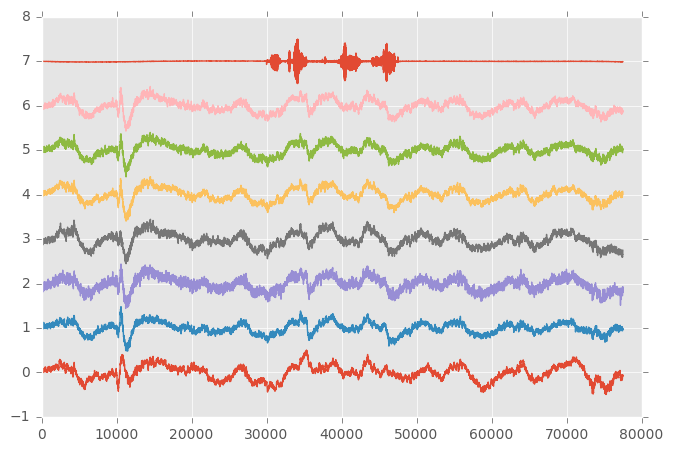

In [5]:
reload(st)
kwd_file = et.open_kwd(bird, sess)
starts = m.get_start()
recs = m.get_rec()

lfp_spectro_pars={'n_window': 512,
                 'n_overlap': 511,
                 'sigma': 30,
                 'f_cut': 150,
                 'db_cut': 0.000065 }

m_starts = kwkf.apply_rec_offset(kwd_file, m.get_start(), m.get_rec())

i_bout = 30
neural_chans = np.array(exp_par['channel_config']['neural'] + [exp_par['channel_config']['mic']])
#neural_chans = np.array(exp_par['channel_config']['neural'])
good_chans = np.array([1, 11, 12, 13, 14, 15, 16, 32])
neural_chans = neural_chans[good_chans]

before = 30000
after = 30000
rec = recs[i_bout]
dset = kwdf.get_data_set(kwd_file, rec)
h5d = st.H5Data(dset, s_f, dtype=np.float)
start = starts[i_bout]

lfp_frame = st.Chunk(h5d, np.array(neural_chans), [start-before, start + m_chunk.samples + after])
lfp_frame.apply_filter(sp.apply_butter_bandpass, filter_pars)

lfp_frame.plot()

2446.66666667
fcut_plot 5.29831736655


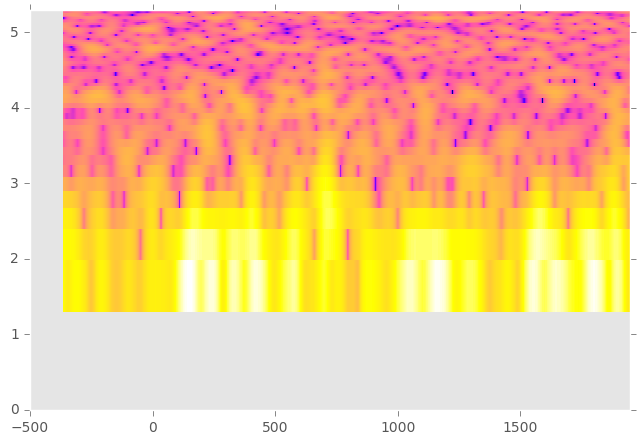

In [10]:
lfp_spectro_pars={'n_window': 2048*4,
                  'n_overlap': 2048*4-4,
                 'sigma': 30*15*2,
                 'f_cut': 200,
                 'db_cut': 0.}

chan = 2
spec_chan = sp.Spectrogram(first_avg.data[:,chan], s_f, **lfp_spectro_pars)
ax=spec_chan.plot(before_ms=500, log_f=True, cmap='gnuplot2')

2017-01-09 14:55:05,533 root         INFO     Collecting 75 frames...
2017-01-09 14:55:05,534 root         INFO     Frame 0 ...
2017-01-09 14:55:06,788 root         INFO     Frame 10 ...
2017-01-09 14:55:08,733 root         INFO     Frame 20 ...
2017-01-09 14:55:09,928 root         INFO     Frame 30 ...
2017-01-09 14:55:10,984 root         INFO     Frame 40 ...
2017-01-09 14:55:15,843 root         INFO     Frame 50 ...
2017-01-09 14:55:20,955 root         INFO     Frame 60 ...
2017-01-09 14:55:23,868 root         INFO     Frame 70 ...


(<matplotlib.figure.Figure at 0x7f195977b510>,
 <matplotlib.axes._axes.Axes at 0x7f19633a0dd0>)

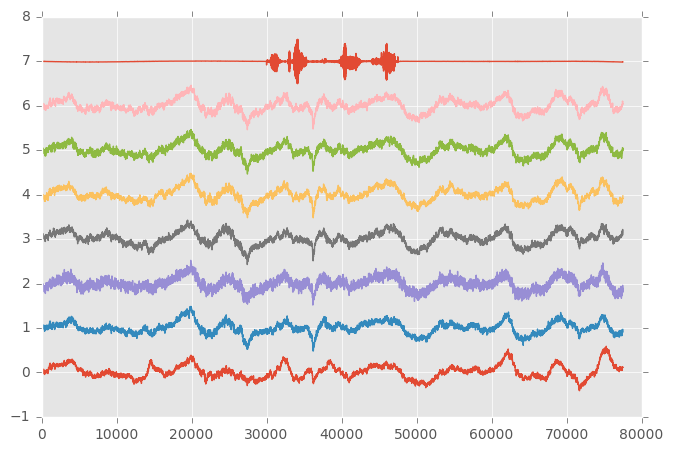

In [7]:
logger.setLevel(logging.INFO)
before = 30000
after = 30000

all_frames = collect_frames(starts-before, before+after+m_chunk.samples, 
                            s_f, 
                            kwd_file, recs, neural_chans)

nothing = list_apply_filter(all_frames, sp.apply_butter_bandpass, filter_pars)

first_avg = list_sum(all_frames)
first_avg.plot()

In [185]:
reload(st)
def collect_frames_stream(starts, span, s_f, kwd_file, recs_list, chan_list):
    recs = np.unique(recs_list)
    logger.info('Collecting {} recs...'.format(recs.size))
    all_frames = []
    for i_rec, rec in enumerate(recs):
        logger.info("Rec {} ...".format(rec))
        stream_obj = st.H5Data(kwdf.get_data_set(kwd_file, rec), 
                               s_f,
                               chan_list=chan_list,
                               dtype=np.float)
        starts_from_rec = starts[recs_list==rec]
        rec_frames = stream_obj.apply_repeated(starts_from_rec, span, lambda x: x)
        all_frames.append(rec_frames)
    return np.concatenate(all_frames_stream, axis=0)

In [177]:
neural_chans[7]

32

In [186]:
all_frames_stream = collect_frames_stream(starts-before, before+after+m_chunk.samples, 
                            s_f, 
                            kwd_file, recs, neural_chans)
all_frames_stream.shape

2016-12-04 15:18:33,130 root         INFO     Collecting 1 recs...
2016-12-04 15:18:33,130 root         INFO     Collecting 1 recs...
2016-12-04 15:18:33,134 root         INFO     Rec 0 ...
2016-12-04 15:18:33,134 root         INFO     Rec 0 ...


(75, 77498, 8)

In [184]:
np.concatenate(all_frames_stream, axis=0).shape

(75, 77498, 8)

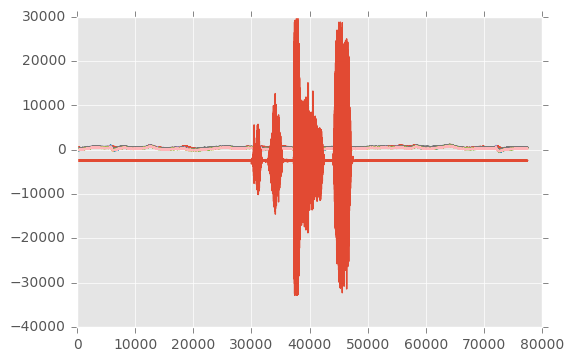

In [188]:
plt.plot(all_frames_stream[0, :, :]);
#plt.plot(all_frames_stream[0][:,:,0])

(<matplotlib.figure.Figure at 0x7fab96be4a50>,
 <matplotlib.axes._axes.Axes at 0x7fab96be4e90>)

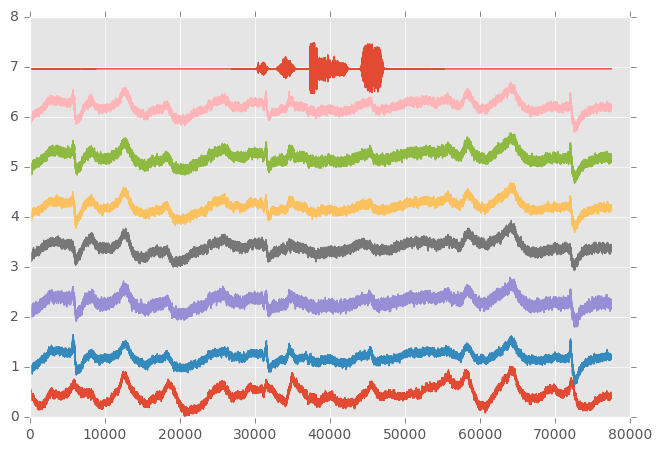

In [157]:
all_frames[0].plot()

In [94]:
corr_start = 30000
corr_span = 20000

chan_pair = [0, 1]

corr_stim = np.corrcoef(aframe.data[corr_start-corr_span:corr_start, chan_pair[0]], 
            aframe.data[corr_start-corr_span:corr_start, chan_pair[1]])[1][0]

corr_no_stim = np.corrcoef(aframe.data[corr_start: corr_span + corr_start, chan_pair[0]], 
            aframe.data[corr_start: corr_span + corr_start, chan_pair[1]])[1][0]

corr_pair = [corr_no_stim, corr_stim]

def channel_correlations(corr_start, corr_span, chan_pair, aframe):
    corr_stim = np.corrcoef(aframe.data[corr_start-corr_span:corr_start, chan_pair[0]], 
            aframe.data[corr_start-corr_span:corr_start, chan_pair[1]])[1][0]

    corr_no_stim = np.corrcoef(aframe.data[corr_start: corr_span + corr_start, chan_pair[0]], 
            aframe.data[corr_start: corr_span + corr_start, chan_pair[1]])[1][0]

    return np.array([corr_no_stim, corr_stim])

def all_channel_correlations(corr_start, corr_span, frame):
    n_ch = len(frame.chan_list)
    all_pairs = [p for p in itertools.combinations(np.arange(n_ch), 2)]
    all_corre = np.zeros((n_ch, n_ch, 2))
    for p in all_pairs:
        all_corre[p[0], p[1], :] = channel_correlations(corr_start, corr_span, p, frame)
    return all_corre
    
def all_frame_correlations(corr_start, corr_span, frames_list):
    return np.stack([all_channel_correlations(30000, 20000, f) for f in frames_list],
                   axis=3)


#channel_correlations(30000, 20000, [0,5], all_frames[7])

afc = all_frame_correlations(30000, 20000, all_frames)


#all_channel_correlations(30000, 20000, all_frames[7])

In [77]:
import itertools
all_pairs = [p for p in itertools.combinations(np.arange(len(aframe.chan_list)), 2)]


In [92]:
all_channel_correlations(30000, 20000, all_frames[7])[0,5]

array([ 0.77566774,  0.50814358])

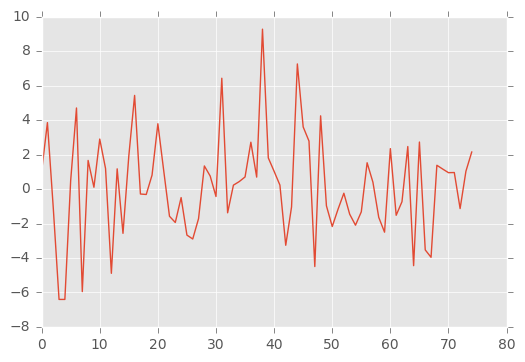

In [103]:
plt.plot(np.diff(np.sum(np.sum(afc[:,:,:,:], axis=0), axis=0), axis=0).T)

In [263]:
def progress_report(i, step=10):
    if i % step == 0:
        logger.info("Frame {} ...".format(i))
        
def compute_spectra(frame_list, *spectro_pars, **spectro_kwpars):
    spectra = []
    s_f = frame_list[0].sound.s_f
    chans = range(len(frame_list[0].chan_list))
    logger.info('Computing spectra for {0} frames, {1} chans'.format(len(frame_list), len(chans)))
    for i, one_frame in enumerate(frame_list):
        progress_report(i, step=10)
        spectra = map(lambda ch: sp.Spectrogram(one_frame.data[:,ch], s_f, 
                                                *spectro_pars, 
                                                **spectro_kwpars),
                      chans)   
        if i==0:
            mean_spectra = spectra
        else:
            mean_spectra = [old + new for (old, new) in zip(spectra, mean_spectra)]
    logger.info('Done computing spectra')
    return spectra

all_spectra = compute_spectra(all_frames, **lfp_spectro_pars)

2016-11-18 16:14:29,704 root         INFO     Computing spectra for 75 frames, 8 chans
2016-11-18 16:14:29,706 root         INFO     Frame 0 ...
2016-11-18 16:22:52,271 root         INFO     Frame 10 ...
2016-11-18 16:31:06,263 root         INFO     Frame 20 ...
2016-11-18 16:39:34,197 root         INFO     Frame 30 ...
2016-11-18 16:47:50,511 root         INFO     Frame 40 ...
2016-11-18 16:56:04,674 root         INFO     Frame 50 ...
2016-11-18 17:04:20,133 root         INFO     Frame 60 ...
2016-11-18 17:12:35,451 root         INFO     Frame 70 ...
2016-11-18 17:16:42,655 root         INFO     Done computing spectra


2310.13333333
fcut_plot 5.0106352941


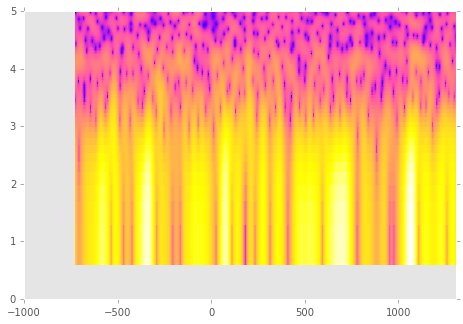

In [252]:
ax=spectr[0].plot(before_ms=1000, log_f=True, cmap='gnuplot2')

In [224]:
frames = []
mean_spectra = []
before = 30000
after = 30000

spectra = []

for i_bout, start in enumerate(starts):
    if i_bout%10 == 0:
        print("Bout {} ...".format(i_bout))
    rec = recs[i_bout]
    one_frame = st.Chunk(st.H5Data(kwdf.get_data_set(kwd_file, rec), 
                                     s_f, 
                                     dtype=np.float), 
                           np.array(neural_chans),
                           [start-before, start + m_chunk.samples + after])
    one_frame.apply_filter(sp.apply_butter_bandpass, filter_pars)
    #one_frame.apply_filter(np.abs)
    frames.append(one_frame)
#     spectra = [sp.Spectrogram(one_frame.data[:,ch], s_f, **lfp_spectro_pars) 
#                for ch in range(len(neural_chans))]
#     if i_bout==0:
#         mean_spectra = spectra
#     else:
#         mean_spectra = [old + new for (old, new) in zip(spectra, mean_spectra)]





Bout 0 ...
Bout 10 ...
Bout 20 ...
Bout 30 ...
Bout 40 ...
Bout 50 ...
Bout 60 ...
Bout 70 ...


In [117]:
spectra = [sp.Spectrogram(one_frame.data[:,ch], s_f, **lfp_spectro_pars) for ch in range(len(neural_chans))]

(<matplotlib.figure.Figure at 0x7fad1a542b50>,
 <matplotlib.axes._axes.Axes at 0x7fad1a627310>)

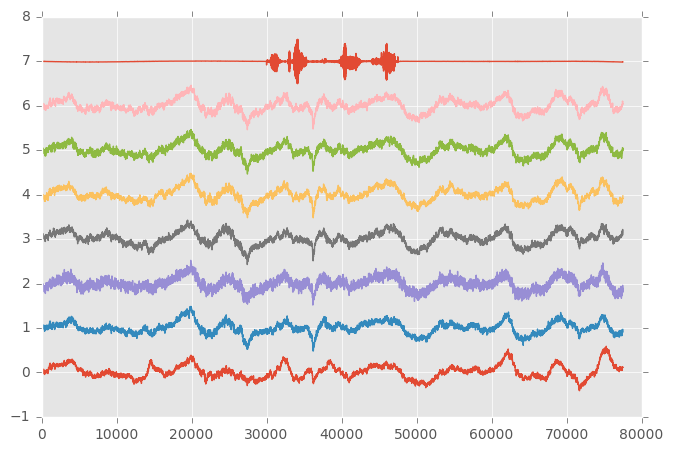

In [14]:
first_avg = list_sum(all_frames)
first_avg.plot()

2310.13333333
fcut_plot 5.0106352941


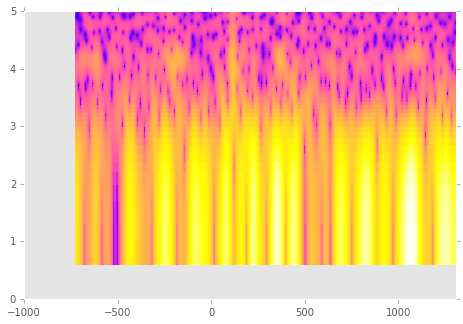

In [207]:
spec_chan = sp.Spectrogram(first_avg.data[:,0], s_f, **lfp_spectro_pars)
ax=spec_chan.plot(before_ms=1000, log_f=True, cmap='gnuplot2')

2310.13333333
fcut_plot 5.0106352941


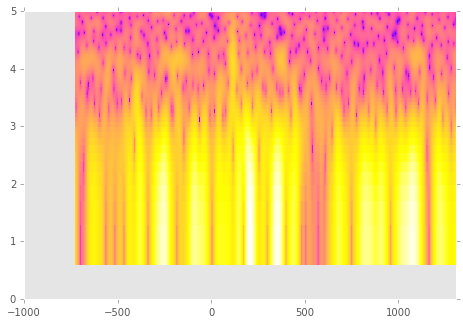

In [208]:
spec_chan = sp.Spectrogram(first_avg.data[:,6], s_f, **lfp_spectro_pars)
ax=spec_chan.plot(before_ms=1000, log_f=True, cmap='gnuplot2')

In [209]:
specs = []
for ch in range(6):
    specs.append(sp.Spectrogram(first_avg.data[:,ch], s_f, **lfp_spectro_pars))


2310.13333333
fcut_plot 5.0106352941


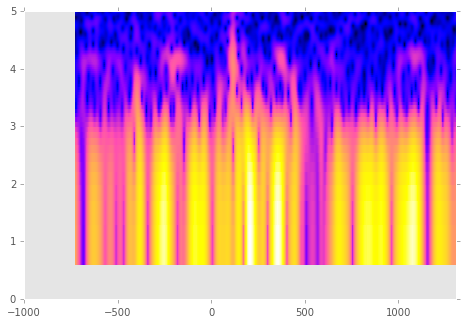

In [210]:
specs_avg = list_sum(specs)
ax=specs_avg.plot(before_ms=1000, log_f=True, cmap='gnuplot2')

850.4


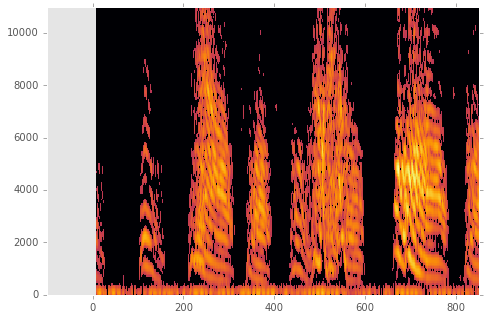

In [16]:
i_bout = 53

rec = recs[i_bout]
start = starts[i_bout]

lfp_frame_2 = st.Chunk(st.H5Data(kwdf.get_data_set(kwd_file, rec), s_f, dtype=np.float),
                     np.array(neural_chans),
                     [start-before, start + m_chunk.samples + after])

spec_chan_2 = sp.Spectrogram(lfp_frame_2.data[:,chan], s_f, **lfp_spectro_pars)
ax_2=spec_chan_2.plot(before_ms=100)

In [18]:
sp3 = spec_chan + spec_chan_2

850.4


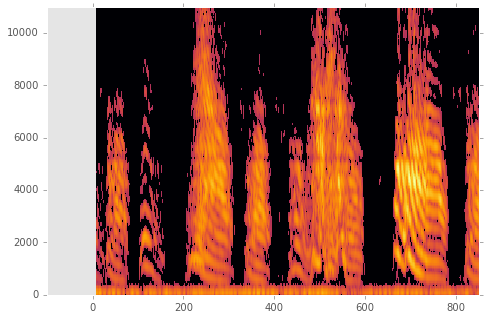

In [19]:
sp3.plot(before_ms=100)

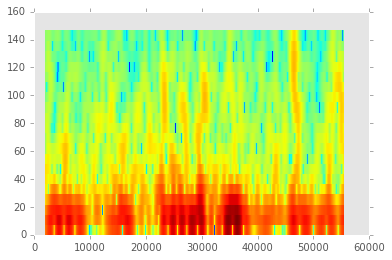

In [80]:
f_cut = 150
n_window = 2048*2
n_overlap = n_window-8

response_spectrogram = spectrogram(lfp_frame.data[:, 1], s_f, 
                                  nperseg = n_window, 
                                  noverlap= n_overlap, 
                                  window = sg.gaussian(n_window, sigma*15), 
                                  scaling='spectrum')

plt.pcolormesh(response_spectrogram[1]*s_f, 
               response_spectrogram[0][response_spectrogram[0] < f_cut], 
               np.log(response_spectrogram[2][response_spectrogram[0] < f_cut, :]))

In [81]:
# quick confirm of the avg lfp
n_trials = starts.size - 1
n_samples = m_chunk.samples + after + before
n_chans = neural_chans.size

spectr_shape = response_spectrogram[2].shape
n_x = spectr_shape[0]
n_y = spectr_shape[1]

spectr = np.empty([n_trials, n_x, n_y])
lfp = np.empty([n_samples, n_trials, n_chans], dtype=np.float)


for i_trial in range(n_trials):
    start = starts[i_trial]
    one_frame = st.Chunk(h5d, np.array(neural_chans), [start-before, start + m_chunk.samples + after])
    lfp[:, i_trial, :] = one_frame.data
    this_spectrogram = spectrogram(one_frame.data[:, 1], s_f, 
                                  nperseg = n_window, 
                                  noverlap= n_overlap, 
                                  window = sg.gaussian(n_window, sigma*50), 
                                  scaling='density')
    spectr[i_trial, :, :] = (this_spectrogram[2])

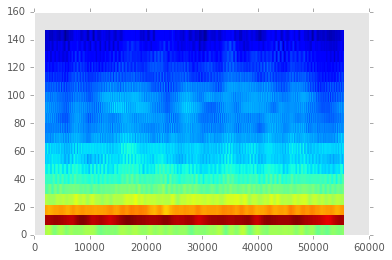

In [74]:
mean_spectr = np.mean(spectr, axis=0)
plt.pcolormesh(response_spectrogram[1]*s_f, 
               response_spectrogram[0][response_spectrogram[0] < f_cut], 
               np.log(mean_spectr[:,:][response_spectrogram[0] < f_cut, :]))

In [17]:
plt.figure(1)
plt.subplot(311)
plt.plot(np.mean(lfp[:, :, 1], axis=1))
plt.subplot(312)
plt.pcolormesh(response_spectrogram[1], 
               response_spectrogram[0][response_spectrogram[0] < f_cut], 
               np.log(mean_spectrogram[2][response_spectrogram[0] < f_cut, :]))
plt.subplot(313)
plt.plot(lfp[:,4,0])
plt.show()
fig_name = os.path.join(fn['folders']['ss'], 'spectrum_avg_{}.png'.format(m_name))
plt.savefig(fig_name, format='png')

(49, 2049, 3680)

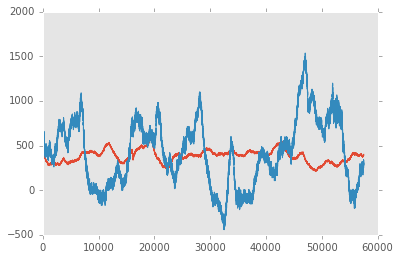

In [82]:
plt.plot(np.mean(lfp[:, :, 1], axis=1))
plt.plot(lfp[:,4,1])

f_cut = 150
n_window = 2048
n_overlap = n_window - 1
response_spectrogram = spectrogram(np.mean(lfp[:, :, 1], axis=1), s_f, 
                                  nperseg = n_window, 
                                  noverlap= n_overlap, 
                                  window = sg.gaussian(n_window, sigma), 
                                  scaling='spectrum')

plt.pcolormesh(response_spectrogram[1], 
               response_spectrogram[0][response_spectrogram[0] < f_cut], 
               np.log(response_spectrogram[2][response_spectrogram[0] < f_cut, :]))

song_file_path = et.file_path(fn, 'ss', 'sng')
fig_name = os.path.join(fn['folders']['ss'], 'trial_vs_avg_{}.png'.format(m_name))
plt.savefig(fig_name, format='png')

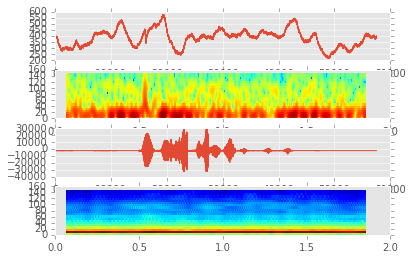

In [83]:
f_cut = 150
n_window = 4096
n_overlap = n_window-8
response_spectrogram = spectrogram(np.mean(lfp[:, :, 1], axis=1), s_f, 
                                  nperseg = n_window, 
                                  noverlap= n_overlap, 
                                  window = sg.gaussian(n_window, sigma*10), 
                                  scaling='spectrum')
plt.figure(3)
plt.subplot(411)
plt.plot(np.mean(lfp[:, :, 1], axis=1))
plt.subplot(412)
plt.pcolormesh(response_spectrogram[1], 
               response_spectrogram[0][response_spectrogram[0] < f_cut], 
               np.log(response_spectrogram[2][response_spectrogram[0] < f_cut, :]))
plt.subplot(413)
plt.plot(lfp[:,4,0])
plt.subplot(414)
plt.pcolormesh(response_spectrogram[1], 
               response_spectrogram[0][response_spectrogram[0] < f_cut], 
               np.log(mean_spectr[:,:][response_spectrogram[0] < f_cut, :]))
fig_name = os.path.join(fn['folders']['ss'], 'spectrum_avg_{}.png'.format(m_name))
plt.savefig(fig_name, format='png')
plt.show()


In [89]:
from bci import expstruct as et
import subprocess
from subprocess import PIPE, CalledProcessError, check_call, Popen


def archive_folder(folder, dest_full_path,
                   dest_file_list=None,
                   compression_pars='xz'):

    logger.info('Archiving folder {0} into {1}'.format(folder, dest_full_path))

    [dest_folder, dest_file] = os.path.split(dest_full_path)
    et.mkdir_p(dest_folder)

    if dest_file_list is None:
        dest_file_list = os.path.join(dest_folder, '{0}.{1}'.format(dest_file, 'lst'))
    
    log_file = os.path.join(dest_folder, '{0}.{1}'.format(dest_file, 'log'))
    
    logger.info('Log file {}'.format(log_file))
    
    cmd = ['tar', '-I \"{}\"'.format(compression_pars), '-cvf',
           dest_full_path, 
           folder,
           '> {}'.format(dest_file_list)]
    
    [root, the_folder] = os.path.split(folder)
    
    cmd = ['tar', '-C {}'.format(root), '-cvf', dest_full_path, the_folder]
    
    with open(log_file, 'w') as f:
        try:
            check_call(cmd, stderr=f)
            df = subprocess.Popen(cmd, stdout=PIPE)
            output, err = df.communicate()
        except CalledProcessError as e:
            logger.warn(e)
            exit(1)

def archive_data(bird, sess, orig, dest=None,
                 compression_pars='pxz -9 -T4',
                 compression_ext='xz'):
    logger.info('Will archive {0} data from bird {1}, sess {2}'.format(orig, bird, sess))
    fn = et.file_names(bird, sess)
    source_folder = fn['folders'][orig]

    logger.info('Source folder: {}'.format(source_folder))
    if dest is None:
        fb = et.file_names('')
        dest_in_archive = os.path.split(os.path.split(fb['folders']['ss'])[0])[1]
        dest = os.path.join(fn['locations']['archive'],
                            dest_in_archive,
                            bird)
    logger.info('Dest. folder: {}'.format(dest))

    zip_ext = 'tar.{0}'.format(compression_ext)
    dest_file = [os.path.join(dest, '{0}.{1}'.format(sess, ext)) for ext in [zip_ext, 'lst']]
    
    archive_folder(source_folder, dest_file[0],
                       dest_file_list=dest_file[1],
                       compression_pars=compression_pars)

#     try:
#         archive_folder(source_folder, dest_file[0],
#                        dest_file_list=dest_file[0],
#                        compression_pars=compression_pars)
#     except:
#         logger.warn('Error archiving {}'.format(dest_file[0]))


In [90]:
archive_data(bird, sess, location)

2016-11-23 15:16:02,722 root         INFO     Will archive rw data from bird z009, sess test_2016-11-04_10-11-24_100
2016-11-23 15:16:02,724 root         INFO     Source folder: /mnt/cube/earneodo/bci_zf/raw_data/z009/test_2016-11-04_10-11-24_100
2016-11-23 15:16:02,725 root         INFO     Dest. folder: /mnt/cube/earneodo/archive/bci_zf/ss_data/z009
2016-11-23 15:16:02,725 root         INFO     Archiving folder /mnt/cube/earneodo/bci_zf/raw_data/z009/test_2016-11-04_10-11-24_100 into /mnt/cube/earneodo/archive/bci_zf/ss_data/z009/test_2016-11-04_10-11-24_100.tar.xz
2016-11-23 15:16:02,726 expstruct    DEBUG    Creating directory /mnt/cube/earneodo/archive/bci_zf/ss_data/z009
2016-11-23 15:16:02,733 expstruct    DEBUG    Directory existed, doing nothing
2016-11-23 15:16:02,734 root         INFO     Log file /mnt/cube/earneodo/archive/bci_zf/ss_data/z009/test_2016-11-04_10-11-24_100.tar.xz.log
2016-11-23 15:16:02,748 root         WARNING  Command '['tar', '-C /mnt/cube/earneodo/bci_zf/

In [73]:
reload(et)
bird = 'z009'
location = 'rw'
sess = 'test_2016-11-04_10-11-24_100'
fn = et.file_names(bird)
fn

{'files': {'base': 'experiment',
  'cand': 'experiment.mot.h5',
  'evt': 'experiment.kwe',
  'kk_par': 'params.prm',
  'kk_prb': '*.prb',
  'ks_cfg': 'config.m',
  'ks_map': 'chanMap.mat',
  'ks_mas': 'master.m',
  'ks_par': 'params.py',
  'mic': 'experiment-rec_000.mic.wav',
  'par': 'experiment.par.yml',
  'sng': 'experiment.sng.kwe',
  'ss_bin': 'experiment.dat',
  'ss_par': 'experiment.par.yml',
  'ss_raw': 'experiment.raw.kwd',
  'stm': 'experiment.stm.kwe',
  'sts': 'experiment-rec_000.sts.wav'},
 'folders': {'kai': '/mnt/cube/kai/results/z009/',
  'prb': '/mnt/cube/earneodo/bci_zf/probes',
  'raw': '/usr/local/experiment/raw_data/z009/',
  'rw': '/mnt/cube/earneodo/bci_zf/raw_data/z009/',
  'ss': '/mnt/cube/earneodo/bci_zf/ss_data/z009/',
  'stim': '/mnt/cube/earneodo/bci_zf/stim_data/z009/',
  'templ': '/mnt/cube/earneodo/bci_zf/templates',
  'tmp': '/usr/local/experiment/tmp_data/z009/'},
 'locations': {'archive': '/mnt/cube/earneodo/archive/bci_zf',
  'experiment': '/mnt/cube

2016-11-23 15:06:57,106 root         INFO     Will archive rw data from bird z009, sess test_2016-11-04_10-11-24_100
2016-11-23 15:06:57,109 root         INFO     Source folder: /mnt/cube/earneodo/bci_zf/raw_data/z009/test_2016-11-04_10-11-24_100
2016-11-23 15:06:57,111 root         INFO     Dest. folder: /mnt/cube/earneodo/archive/bci_zf/ss_data/z009
2016-11-23 15:06:57,113 root         INFO     Archiving folder /mnt/cube/earneodo/bci_zf/raw_data/z009/test_2016-11-04_10-11-24_100 into /mnt/cube/earneodo/archive/bci_zf/ss_data/z009/test_2016-11-04_10-11-24_100.tar.xz
2016-11-23 15:06:57,114 expstruct    DEBUG    Creating directory /mnt/cube/earneodo/archive/bci_zf/ss_data/z009
2016-11-23 15:06:57,117 expstruct    DEBUG    Directory existed, doing nothing
2016-11-23 15:06:57,119 root         INFO     Log file /mnt/cube/earneodo/archive/bci_zf/ss_data/z009/test_2016-11-04_10-11-24_100.tar.xz.log


In [31]:
fn['locations']['archive']

'/mnt/cube/earneodo/archive/bci_zf'

In [34]:
from subprocess import PIPE, CalledProcessError, check_call, Popen

try:
    check_call(["ls", "/home/non"])
    df = subprocess.Popen(["ls", "/home/non"], stdout=PIPE)
    output, err = df.communicate()
except CalledProcessError as e:
    print(e)
    exit(1)

Command '['ls', '/home/non']' returned non-zero exit status 2
